# In this code, we are fine-tuning the pre-trained ResNet101 model in a supervised manner and evaluating the model on seen and unseen test data

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import numpy as np
import scipy.io as sio
from numpy import expand_dims
from numpy import asarray
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from skimage.filters import gabor_kernel
from scipy import ndimage as nd        
import matplotlib
import matplotlib.pyplot as plt    
from numpy.linalg import norm
from keras.optimizers import SGD, Adam, Adagrad
import graphviz
import pydot

# Define the Path and prepare the Dataset

In [2]:
data_path = 'E:/Sushree/Dataset/'

img_path = os.path.join(data_path,'CUB_200_2011/CUB_200_2011/images/')
print(img_path)

print(len(os.listdir(img_path)))

def get_imlist(path, option):
    if option == 'jpg':
        return[os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    
def prepare_dataset(img_path, width, height, option):
    folder_list = os.listdir(img_path)
    num_classes = len(folder_list)
    images = []
    labels = []
    for i in range(len(folder_list)):
        print(i)
        img_list = get_imlist(os.path.join(img_path, folder_list[i]), option)
        for j in range(len(img_list)):
            img = image.load_img(img_list[j], target_size = (width, height))
            img = np.array(img)
            #img = np.true_divide(img,[255.0], out = None)
            img = np.divide(np.subtract(img, np.mean(img)), np.std(img))
            x = image.img_to_array(img)
            images.append(x)
            labels.append(i)
    images = np.array(images, dtype = np.float32)                             
    labels = to_categorical(labels, num_classes)                             
    return images, labels 


width, height, ch = 224, 224, 3
images, labels = prepare_dataset(img_path, width, height,'jpg') 

print(images.shape)
print(len(labels), labels.shape)

E:/Sushree/Dataset/CUB_200_2011/CUB_200_2011/images/
200
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(11788, 224, 224, 3)
11788 (11788, 200)


# Prepare data for Training and Test

In [3]:

split_path = os.path.join(data_path,'data/xlsa17/data/CUB/att_splits.mat')
matcontent = sio.loadmat(split_path)
trainval_loc = matcontent['trainval_loc'].squeeze() - 1

print(trainval_loc, len(trainval_loc))

train_images = images[trainval_loc]
print(train_images.shape)

train_labels = labels[trainval_loc]
print(len(train_labels), train_labels.shape)


X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 16
train_gen = DataGenerator(X_train, y_train, batch_size)   
val_gen = DataGenerator(X_val, y_val, batch_size)


[10876 10920  2652 ...  5226 11507  1642] 7057
(7057, 224, 224, 3)
7057 (7057, 200)


# Define the CNN and perform full finetuning by training the whole model

In [4]:
model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

model.summary()

x = model.output
out = GlobalAveragePooling2D()(x)
pred = Dense(200, activation='softmax')(out)

new_model = Model(inputs = model.input, outputs = pred)
new_model.summary()


for layer in new_model.layers:
    layer.trainable = True
    
    
sgd = SGD(learning_rate = 1e-2, decay = 1e-6, momentum = 0.9, nesterov = True)
new_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

train_summary = new_model.fit(train_gen, epochs = 200, verbose = 1, callbacks = None, validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)
        

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, None, None,   16640       ['pool1_pool[0][0]']             
                                256)                                                              
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block1_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block1_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv3_block3_add (Add)         (None, None, None,   0           ['conv3_block2_out[0][0]',       
                                512)                              'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, None, None,   0           ['conv3_block3_add[0][0]']       
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, None, None,   0          ['conv4_block2_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block2_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block2_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block7_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block7_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block7_add (Add)         (None, None, None,   0           ['conv4_block6_out[0][0]',       
                                1024)                             'conv4_block7_3_bn[0][0]']      
                                                                                                  
 conv4_block7_out (Activation)  (None, None, None,   0           ['conv4_block7_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
          

                                                                                                  
 conv4_block10_2_relu (Activati  (None, None, None,   0          ['conv4_block10_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block10_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block10_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block10_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block13_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block13_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block15_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block18_add (Add)        (None, None, None,   0           ['conv4_block17_out[0][0]',      
                                1024)                             'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, None, None,   0          ['conv4_block18_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block18_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block1_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block1_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, None, None,   0          ['conv5_block1_2_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, None, None,   2099200     ['conv4_block23_out[0][0]']      
          

                                                                                                  
 conv5_block3_out (Activation)  (None, None, None,   0           ['conv5_block3_add[0][0]']       
                                2048)                                                             
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 200)          409800      ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
Total para

Epoch 49/200
22/22 [==============================] - 3s 157ms/step - loss: 0.2905 - accuracy: 0.9205 - val_loss: 2.4697 - val_accuracy: 0.5125
Epoch 50/200
22/22 [==============================] - 3s 157ms/step - loss: 0.4138 - accuracy: 0.8835 - val_loss: 2.6577 - val_accuracy: 0.4125
Epoch 51/200
22/22 [==============================] - 3s 157ms/step - loss: 0.6642 - accuracy: 0.7898 - val_loss: 3.0119 - val_accuracy: 0.3500
Epoch 52/200
22/22 [==============================] - 3s 157ms/step - loss: 0.5260 - accuracy: 0.8523 - val_loss: 2.4727 - val_accuracy: 0.4250
Epoch 53/200
22/22 [==============================] - 3s 158ms/step - loss: 0.6754 - accuracy: 0.8068 - val_loss: 3.5084 - val_accuracy: 0.3375
Epoch 54/200
22/22 [==============================] - 3s 158ms/step - loss: 0.5272 - accuracy: 0.8551 - val_loss: 3.0925 - val_accuracy: 0.3875
Epoch 55/200
22/22 [==============================] - 3s 158ms/step - loss: 0.3817 - accuracy: 0.9062 - val_loss: 2.7900 - val_accuracy:

Epoch 106/200
22/22 [==============================] - 3s 159ms/step - loss: 0.0462 - accuracy: 0.9886 - val_loss: 2.2141 - val_accuracy: 0.5625
Epoch 107/200
22/22 [==============================] - 3s 159ms/step - loss: 0.0125 - accuracy: 0.9972 - val_loss: 2.1755 - val_accuracy: 0.5500
Epoch 108/200
22/22 [==============================] - 3s 159ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 2.0315 - val_accuracy: 0.5750
Epoch 109/200
22/22 [==============================] - 3s 158ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.9908 - val_accuracy: 0.5625
Epoch 110/200
22/22 [==============================] - 3s 158ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 2.0051 - val_accuracy: 0.5750
Epoch 111/200
22/22 [==============================] - 3s 157ms/step - loss: 0.0293 - accuracy: 0.9943 - val_loss: 2.1102 - val_accuracy: 0.5000
Epoch 112/200
22/22 [==============================] - 3s 158ms/step - loss: 0.0418 - accuracy: 0.9886 - val_loss: 2.2153 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


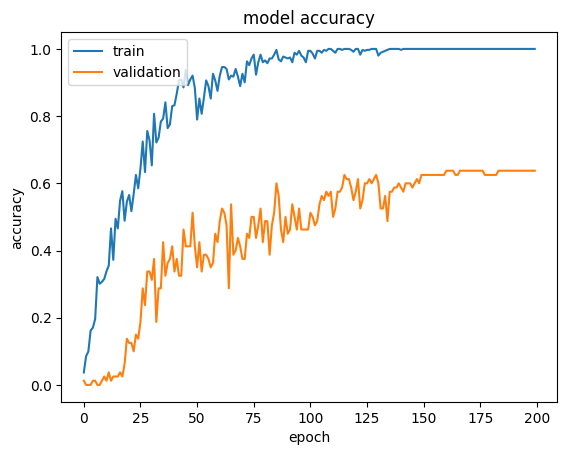

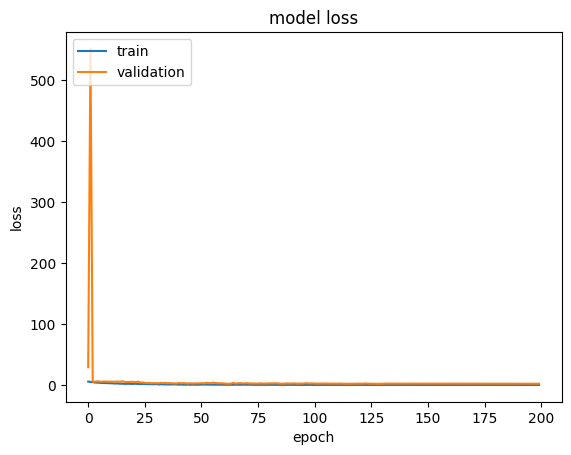

<Figure size 640x480 with 0 Axes>

In [5]:
name = 'ResNet101_CUB_224_finetune_200eph_16bch_1e-2lr'
save_path = 'C:/Users/Admin/Sushree_Codes/Sush_2/Results/'

new_model.save_weights(save_path + 'Wt_' + name + '.h5')


print(train_summary.history.keys())

plt.plot(train_summary.history['accuracy'])
plt.plot(train_summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Acc_' + name + '.png')

plt.plot(train_summary.history['loss'])
plt.plot(train_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Loss_' + name + '.png')

In [6]:

test_seen_loc = matcontent['test_seen_loc'].squeeze() - 1
print(test_seen_loc, len(test_seen_loc))

test_seen_images = images[test_seen_loc]
test_seen_labels = labels[test_seen_loc]
print(test_seen_images.shape)
print(len(test_seen_labels))

test_unseen_loc = matcontent['test_unseen_loc'].squeeze() - 1
print(test_unseen_loc, len(test_unseen_loc))

test_unseen_images = images[test_unseen_loc]
test_unseen_labels = labels[test_unseen_loc]
print(test_unseen_images.shape)
print(len(test_unseen_labels))


[ 8971  8570  1473 ... 10612  7664  5895] 1764
(1764, 224, 224, 3)
1764
[  178   179   180 ... 11785 11786 11787] 2967
(2967, 224, 224, 3)
2967


In [7]:
test_seen_gen = DataGenerator(test_seen_images, test_seen_labels, batch_size)
new_model.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_labels, batch_size)
new_model.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)

11/11 [==============================] - 1s 44ms/step - loss: 18.6216 - accuracy: 0.0000e+00


[18.621570587158203, 0.0]

# Define the CNN and perform partial finetuning by training the additional layers only

In [8]:
model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

for layer in model.layers:
    layer.trainable = False
model.summary()

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
out = BatchNormalization()(x)
pred = Dense(200, activation='softmax')(out)

new_model = Model(inputs = model.input, outputs = pred)
new_model.summary()

    
sgd = SGD(learning_rate = 1e-2, decay = 1e-6, momentum = 0.9, nesterov = True)
new_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

train_summary = new_model.fit(train_gen, epochs = 200, verbose = 1, callbacks = None, validation_data = val_gen, 
                              shuffle = True, steps_per_epoch = len(train_gen)//batch_size, 
                              validation_steps = len(val_gen)//batch_size)
        

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                       

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv4_block9_1_relu (Activatio  (None, None, None,   0          ['conv4_block9_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block9_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block9_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block9_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block9_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block9_2_relu (Activatio  (None, None, None,   0          ['conv4_block9_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block11_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block12_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block12_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block12_1_relu (Activati  (None, None, None,   0          ['conv4_block12_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

 lization)                      1024)                                                             
                                                                                                  
 conv4_block14_add (Add)        (None, None, None,   0           ['conv4_block13_out[0][0]',      
                                1024)                             'conv4_block14_3_bn[0][0]']     
                                                                                                  
 conv4_block14_out (Activation)  (None, None, None,   0          ['conv4_block14_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block14_out[0][0]']      
                                256)                                                              
          

 conv4_block17_2_relu (Activati  (None, None, None,   0          ['conv4_block17_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block17_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block17_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block17_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block17_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block17_add (Add)        (None, None, None,   0           ['conv4_block16_out[0][0]',      
          

                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block20_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block20_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block20_2_relu (Activati  (None, None, None,   0          ['conv4_block20_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_blo

                                256)                                                              
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block23_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block23_1_relu (Activati  (None, None, None,   0          ['conv4_block23_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block23_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block23_1_relu[0][0]']   
                                256)                                                              
          

 conv5_block2_3_conv (Conv2D)   (None, None, None,   1050624     ['conv5_block2_2_relu[0][0]']    
                                2048)                                                             
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, None, None,   8192       ['conv5_block2_3_conv[0][0]']    
 ization)                       2048)                                                             
                                                                                                  
 conv5_block2_add (Add)         (None, None, None,   0           ['conv5_block1_out[0][0]',       
                                2048)                             'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, None, None,   0           ['conv5_block2_add[0][0]']       
          

                                                                                                  
 conv2_block1_2_relu (Activatio  (None, None, None,   0          ['conv2_block1_2_bn[0][0]']      
 n)                             64)                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, None, None,   16640       ['pool1_pool[0][0]']             
                                256)                                                              
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, None, None,   16640       ['conv2_block1_2_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block1_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, None, None,   0          ['conv3_block1_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, None, None,   147584      ['conv3_block1_1_relu[0][0]']    
                                128)                                                              
          

 conv3_block3_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block3_2_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, None, None,   2048       ['conv3_block3_3_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv3_block3_add (Add)         (None, None, None,   0           ['conv3_block2_out[0][0]',       
                                512)                              'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, None, None,   0           ['conv3_block3_add[0][0]']       
          

                                                                                                  
 conv4_block2_1_relu (Activatio  (None, None, None,   0          ['conv4_block2_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block2_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block2_2_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_blo

                                1024)                                                             
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block4_out[0][0]']       
                                256)                                                              
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block5_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, None, None,   0          ['conv4_block5_1_bn[0][0]']      
 n)                             256)                                                              
          

 conv4_block7_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block7_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block7_add (Add)         (None, None, None,   0           ['conv4_block6_out[0][0]',       
                                1024)                             'conv4_block7_3_bn[0][0]']      
                                                                                                  
 conv4_block7_out (Activation)  (None, None, None,   0           ['conv4_block7_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   262400      ['conv4_block7_out[0][0]']       
          

                                                                                                  
 conv4_block10_2_relu (Activati  (None, None, None,   0          ['conv4_block10_2_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block10_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block10_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block10_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block10_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block13_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block13_1_relu[0][0]']   
                                256)                                                              
                                                                                                  
 conv4_block13_2_bn (BatchNorma  (None, None, None,   1024       ['conv4_block13_2_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block13_2_relu (Activati  (None, None, None,   0          ['conv4_block13_2_bn[0][0]']     
 on)                            256)                                                              
          

 conv4_block16_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block15_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, None, None,   1024       ['conv4_block16_1_conv[0][0]']   
 lization)                      256)                                                              
                                                                                                  
 conv4_block16_1_relu (Activati  (None, None, None,   0          ['conv4_block16_1_bn[0][0]']     
 on)                            256)                                                              
                                                                                                  
 conv4_block16_2_conv (Conv2D)  (None, None, None,   590080      ['conv4_block16_1_relu[0][0]']   
          

                                                                                                  
 conv4_block18_add (Add)        (None, None, None,   0           ['conv4_block17_out[0][0]',      
                                1024)                             'conv4_block18_3_bn[0][0]']     
                                                                                                  
 conv4_block18_out (Activation)  (None, None, None,   0          ['conv4_block18_add[0][0]']      
                                1024)                                                             
                                                                                                  
 conv4_block19_1_conv (Conv2D)  (None, None, None,   262400      ['conv4_block18_out[0][0]']      
                                256)                                                              
                                                                                                  
 conv4_blo

 on)                            256)                                                              
                                                                                                  
 conv4_block21_3_conv (Conv2D)  (None, None, None,   263168      ['conv4_block21_2_relu[0][0]']   
                                1024)                                                             
                                                                                                  
 conv4_block21_3_bn (BatchNorma  (None, None, None,   4096       ['conv4_block21_3_conv[0][0]']   
 lization)                      1024)                                                             
                                                                                                  
 conv4_block21_add (Add)        (None, None, None,   0           ['conv4_block20_out[0][0]',      
                                1024)                             'conv4_block21_3_bn[0][0]']     
          

 conv5_block1_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block1_1_relu[0][0]']    
                                512)                                                              
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, None, None,   2048       ['conv5_block1_2_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, None, None,   0          ['conv5_block1_2_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, None, None,   2099200     ['conv4_block23_out[0][0]']      
          

                                                                                                  
 conv5_block3_out (Activation)  (None, None, None,   0           ['conv5_block3_add[0][0]']       
                                2048)                                                             
                                                                                                  
 global_average_pooling2d_1 (Gl  (None, 2048)        0           ['conv5_block3_out[0][0]']       
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_1 (Dense)                (None, 1024)         2098176     ['global_average_pooling2d_1[0][0
                                                                 ]']                              
                                                                                                  
 batch_nor

Epoch 46/200
22/22 [==============================] - 1s 56ms/step - loss: 2.7915 - accuracy: 0.3438 - val_loss: 5.2685 - val_accuracy: 0.0750
Epoch 47/200
22/22 [==============================] - 1s 56ms/step - loss: 3.7437 - accuracy: 0.2386 - val_loss: 5.3987 - val_accuracy: 0.0875
Epoch 48/200
22/22 [==============================] - 1s 56ms/step - loss: 3.1470 - accuracy: 0.3040 - val_loss: 5.2984 - val_accuracy: 0.0875
Epoch 49/200
22/22 [==============================] - 1s 56ms/step - loss: 3.5625 - accuracy: 0.2415 - val_loss: 5.3219 - val_accuracy: 0.1125
Epoch 50/200
22/22 [==============================] - 1s 55ms/step - loss: 3.0558 - accuracy: 0.3239 - val_loss: 5.3608 - val_accuracy: 0.1000
Epoch 51/200
22/22 [==============================] - 1s 55ms/step - loss: 3.3385 - accuracy: 0.2693 - val_loss: 5.2823 - val_accuracy: 0.0875
Epoch 52/200
22/22 [==============================] - 1s 56ms/step - loss: 2.9261 - accuracy: 0.3693 - val_loss: 5.2234 - val_accuracy: 0.0750

Epoch 160/200
22/22 [==============================] - 1s 57ms/step - loss: 1.8301 - accuracy: 0.5483 - val_loss: 6.6308 - val_accuracy: 0.1000
Epoch 161/200
22/22 [==============================] - 1s 57ms/step - loss: 1.7106 - accuracy: 0.5767 - val_loss: 6.3895 - val_accuracy: 0.1000
Epoch 162/200
22/22 [==============================] - 1s 56ms/step - loss: 1.8858 - accuracy: 0.5511 - val_loss: 6.1769 - val_accuracy: 0.0875
Epoch 163/200
22/22 [==============================] - 1s 57ms/step - loss: 1.7490 - accuracy: 0.5909 - val_loss: 6.3763 - val_accuracy: 0.1375
Epoch 164/200
22/22 [==============================] - 1s 56ms/step - loss: 1.5141 - accuracy: 0.6392 - val_loss: 6.5772 - val_accuracy: 0.0875
Epoch 165/200
22/22 [==============================] - 1s 57ms/step - loss: 1.8231 - accuracy: 0.5369 - val_loss: 6.4473 - val_accuracy: 0.1250
Epoch 166/200
22/22 [==============================] - 1s 57ms/step - loss: 2.1755 - accuracy: 0.5085 - val_loss: 6.5406 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


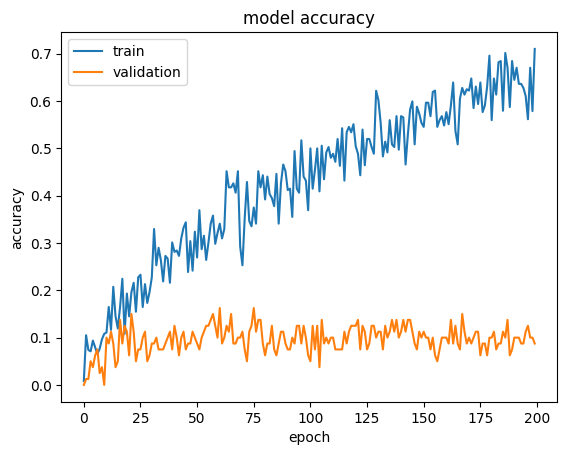

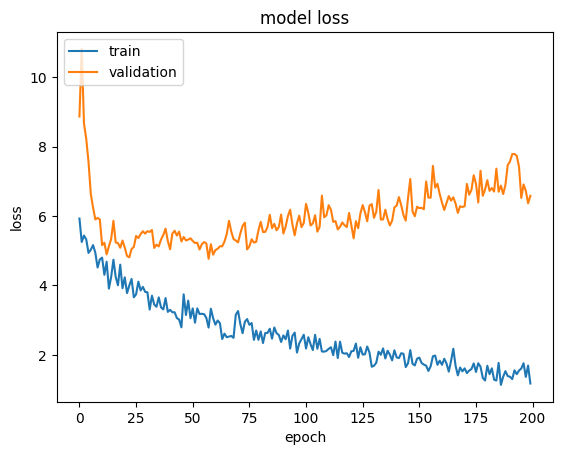

<Figure size 640x480 with 0 Axes>

In [9]:
name = 'ResNet101_CUB_224_partial_finetune_200eph_16bch_1e-2lr'
save_path = 'C:/Users/Admin/Sushree_Codes/Sush_2/Results/'

new_model.save_weights(save_path + 'Wt_' + name + '.h5')


print(train_summary.history.keys())

plt.plot(train_summary.history['accuracy'])
plt.plot(train_summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Acc_' + name + '.png')

plt.plot(train_summary.history['loss'])
plt.plot(train_summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()
plt.savefig(save_path + 'Loss_' + name + '.png')

In [10]:
test_seen_gen = DataGenerator(test_seen_images, test_seen_labels, batch_size)
new_model.evaluate(test_seen_gen, steps = len(test_seen_gen)//batch_size, verbose = 1)

test_unseen_gen = DataGenerator(test_unseen_images, test_unseen_labels, batch_size)
new_model.evaluate(test_unseen_gen, steps = len(test_unseen_gen)//batch_size, verbose = 1)

11/11 [==============================] - 1s 43ms/step - loss: 12.5032 - accuracy: 0.0000e+00


[12.503155708312988, 0.0]

# Results

Full finetuning:
Total params: 43,067,976, Trainable params: 42,962,632, Non-trainable params: 105,344

Training:
Epoch 200/200
loss: 5.0504e-04 - accuracy: 1.0000 - val_loss: 1.9845 - val_accuracy: 0.6375

Testing:
Seen classes: loss: 2.0554 - accuracy: 0.5938
Unseen classes: loss: 18.6216 - accuracy: 0.0000e+00

Partial finetuning:
Total params: 44,965,448, Trainable params: 2,305,224, Non-trainable params: 42,660,224

Training:
Epoch 200/200
loss: 1.1717 - accuracy: 0.7102 - val_loss: 6.5850 - val_accuracy: 0.0875

Testing:
Seen classes: loss: 7.1243 - accuracy: 0.0521
Unseen classes: loss: 12.5032 - accuracy: 0.0000e+00
